In [ ]:
# abandoned
def swap_obj(ind, num_s, num_d):
    if num_s == num_d:
        return
    global df
    arr_s = [f'obj{num_s}_class',
            f'obj{num_s}_x', f'obj{num_s}_y', f'obj{num_s}_w', f'obj{num_s}_h',
            f'obj{num_s}_confidence']
    arr_d = [f'obj{num_d}_class',
            f'obj{num_d}_x', f'obj{num_d}_y', f'obj{num_d}_w', f'obj{num_d}_h',
            f'obj{num_d}_confidence']
    temp = df.loc[ind, arr_d].values
    df.loc[ind, arr_d] = df.loc[ind, arr_s].values
    df.loc[ind, arr_s] = temp

def clear_obj(ind, num_s):
    global df
    arr_s = [f'obj{num_s}_class',
            f'obj{num_s}_x', f'obj{num_s}_y', f'obj{num_s}_w', f'obj{num_s}_h',
            f'obj{num_s}_confidence']
    df.loc[ind, arr_s] = np.NaN

df = pd.read_csv('result_df.csv')
for i in range(0, len(df)):
    ball_ind = 0
    print(i)
    for j in range(1, 33):
        if df.loc[i][f'obj{j}_class'] == 'sports ball':
            ball_ind += 1
            swap_obj(i, j, ball_ind)
            continue
        elif df.loc[i][f'obj{j}_class'] == 'person':
            continue
        clear_obj(i, j)

for j in range(1, 33):
    for i in df.loc[(df[f'obj{j}_class'] == 'sports ball') & (df[f'obj{1}_class'] != 'sports ball')].index:
        swap_obj(i, j, 1)
    for i in df.loc[(df[f'obj{j}_class'] != 'sports ball') & (df[f'obj{j}_class'] != 'person')].index:
        clear_obj(i, j)
    print(df[f'obj{j}_class'].value_counts())

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

err_tol = {
    'challenge': [ 0.30, 0.40, 0.50, 0.60, 0.70 ],
    'play': [ 0.15, 0.20, 0.25, 0.30, 0.35 ],
    'throwin': [ 0.15, 0.20, 0.25, 0.30, 0.35 ]
}

video_id_split = {
    'val':[
         '3c993bd2_0',
         '3c993bd2_1',
    ],
    'train':[
         '1606b0e6_0',
         '1606b0e6_1',
         '35bd9041_0',
         '35bd9041_1',
        #  '407c5a9e_1',
        #  '4ffd5986_0',
        #  '9a97dae4_1',
         'cfbe2e94_0',
         'cfbe2e94_1',
        #  'ecf251d4_0',
    ]
}

event_names = ['challenge', 'throwin', 'play']

event_names_with_background = ['background','challenge','play','throwin']

label_dict = {
    'background':0,
    'challenge':1,
    'play':2,
    'throwin':3,
}

generate_label = False
if generate_label:
    tol_level = 4 # 0~4
    df_label = pd.read_csv('../input/dfl-bundesliga-data-shootout/train.csv')
    for video_id in video_id_split['train']:
        df_result = pd.read_csv(f'result/result_{video_id}.csv')
        df_result_labeled = pd.concat([pd.DataFrame(columns = ['label']), df_result], axis = 1)
        for num_event in range(3):
            event = event_names[num_event]
            tolerance = err_tol[event][tol_level] * 25
            df_label_temp = df_label.loc[df_label.video_id == video_id].loc[df_label.event == event]
            df_label_temp['frame'] = df_label_temp['time'] * 25
            for frame in df_label_temp.frame:
                df_result_labeled.loc[(frame - tolerance <= df_result_labeled.frame_id) & (df_result_labeled.frame_id<= frame + tolerance), 'label'] = event
        df_result_labeled.label = df_result_labeled.label.fillna('background')
        df_result_labeled.to_csv(f'result/result_labeled_{video_id}.csv', index = False)

In [4]:
def rolling_window(arr, window):
    shape = (arr.shape[0] - window + 1,) + (arr.shape[1] * window,)
    strides = (arr.shape[1] * arr.itemsize, arr.itemsize)
    return np.lib.stride_tricks.as_strided(arr, shape = shape, strides = strides)

df_input = pd.DataFrame()
for video_id in video_id_split['train']:
    df_result = pd.read_csv(f'result/result_labeled_{video_id}.csv')
    df_input = pd.concat([df_input, df_result], ignore_index = True)
df_answer = df_input.label

train_all = False
if train_all:
    df_input = df_input.drop(columns = ['label', 'video_id', 'frame_id'])
    df_input = pd.concat([pd.DataFrame(index = [0, 1, 2, 3]), df_input, pd.DataFrame(index = [0, 1, 2, 3])]).fillna(0)
    features_numpy = rolling_window(df_input.values, 9)
    targets_numpy = df_answer.map(label_dict).values

if not train_all:
    df_len = len(df_input)
    # background
    idx_input = []
    num_event = df_answer.loc[df_answer == 'background'].index
    for i in num_event:
        if (i >= 7) & (i < df_len - 7):
            idx_input.append(i - 7)
            idx_input.append(i - 6)
            idx_input.append(i - 5)
            idx_input.append(i - 4)
            idx_input.append(i - 3)
            idx_input.append(i - 2)
            idx_input.append(i - 1)
            idx_input.append(i)
            idx_input.append(i + 1)
            idx_input.append(i + 2)
            idx_input.append(i + 3)
            idx_input.append(i + 4)
            idx_input.append(i + 5)
            idx_input.append(i + 6)
            idx_input.append(i + 7)
    df_input_background = df_input.loc[idx_input]
    print('background: ', len(df_input_background))
    # challenge
    idx_input = []
    num_event = df_answer.loc[df_answer == 'challenge'].index
    for j in range(115):
        for i in num_event:
            if (i >= 7) & (i < df_len - 7):
                idx_input.append(i - 7)
                idx_input.append(i - 6)
                idx_input.append(i - 5)
                idx_input.append(i - 4)
                idx_input.append(i - 3)
                idx_input.append(i - 2)
                idx_input.append(i - 1)
                idx_input.append(i)
                idx_input.append(i + 1)
                idx_input.append(i + 2)
                idx_input.append(i + 3)
                idx_input.append(i + 4)
                idx_input.append(i + 5)
                idx_input.append(i + 6)
                idx_input.append(i + 7)
    df_input_challenge = df_input.loc[idx_input]
    print('challenge: ', len(df_input_challenge))
    # play
    idx_input = []
    num_event = df_answer.loc[df_answer == 'play'].index
    for j in range(36):
        for i in num_event:
            if (i >= 7) & (i < df_len - 7):
                idx_input.append(i - 7)
                idx_input.append(i - 6)
                idx_input.append(i - 5)
                idx_input.append(i - 4)
                idx_input.append(i - 3)
                idx_input.append(i - 2)
                idx_input.append(i - 1)
                idx_input.append(i)
                idx_input.append(i + 1)
                idx_input.append(i + 2)
                idx_input.append(i + 3)
                idx_input.append(i + 4)
                idx_input.append(i + 5)
                idx_input.append(i + 6)
                idx_input.append(i + 7)
    df_input_play = df_input.loc[idx_input]
    print('play: ', len(df_input_play))
    # throwin
    idx_input = []
    num_event = df_answer.loc[df_answer == 'throwin'].index
    for j in range(650):
        for i in num_event:
            if (i >= 7) & (i < df_len - 7):
                idx_input.append(i - 7)
                idx_input.append(i - 6)
                idx_input.append(i - 5)
                idx_input.append(i - 4)
                idx_input.append(i - 3)
                idx_input.append(i - 2)
                idx_input.append(i - 1)
                idx_input.append(i)
                idx_input.append(i + 1)
                idx_input.append(i + 2)
                idx_input.append(i + 3)
                idx_input.append(i + 4)
                idx_input.append(i + 5)
                idx_input.append(i + 6)
                idx_input.append(i + 7)
    df_input_throwin = df_input.loc[idx_input]
    print('throwin: ', len(df_input_throwin))

    df_input = pd.concat([df_input_background, df_input_challenge, df_input_play, df_input_throwin])
    targets_numpy = df_input.label.map(label_dict).values[7::15]
    df_input = df_input.drop(columns = ['label', 'video_id', 'frame_id'])
    features_numpy = df_input.fillna(0).values.reshape(-1, 990)

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.02,
                                                                             random_state = 42)
featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor) # data type is float
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long
featuresTest = torch.from_numpy(features_test).type(torch.FloatTensor) # data type is float
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 1000
n_iters = 40000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True)

background:  1525290
challenge:  1521450
play:  1528200
throwin:  1521000
100


In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # batch_first=True (batch_dim, seq_dim, feature_dim)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach().cuda(), c0.detach().cuda()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
input_dim = 66
hidden_dim = 128
layer_dim = 1
output_dim = 4
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).cuda()

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

model.load_state_dict(torch.load('LSTM.pt'))

<All keys matched successfully>

In [ ]:
# Number of steps to unroll
seq_dim = 15  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader, mininterval=1)):
        images = images.cuda()
        labels = labels.cuda()
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = error(outputs, labels)

        # Getting gradients
        loss.backward()

        # Updating parameters
        optimizer.step()

        count += 1

        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.cuda()
                labels = labels.cuda()
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(count, loss.data.item(), accuracy))

        if count % 5000 == 0:
            torch.save(model.state_dict(), f'LSTM_count{count}_acc{int(accuracy)}.pt')

In [9]:
torch.save(model.state_dict(), 'LSTM.pt')
test = featuresTest[0:100].cuda()
model.load_state_dict(torch.load('LSTM.pt'))
outputs = model(test.view(-1, seq_dim, input_dim))
predicted = torch.max(outputs.data, 1)[1]
print(predicted)
print(targetsTest[0:100])

tensor([3, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 3, 3,
        1, 2, 1, 1, 1, 0, 0, 0, 1, 3, 3, 0, 2, 2, 3, 0, 1, 0, 1, 2, 1, 3, 0, 3,
        1, 2, 2, 3, 0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 2, 3, 0, 0, 3, 2, 0, 1, 0, 0,
        2, 0, 2, 3, 3, 3, 1, 0, 0, 2, 2, 1, 2, 1, 0, 0, 3, 2, 1, 3, 3, 0, 3, 3,
        3, 1, 2, 1], device='cuda:0')
tensor([3, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 3, 3,
        1, 2, 1, 1, 1, 0, 0, 0, 1, 3, 3, 0, 2, 2, 3, 0, 1, 0, 1, 2, 1, 3, 0, 3,
        1, 2, 2, 3, 0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 0, 3, 0, 0, 3, 2, 0, 1, 0, 0,
        2, 0, 2, 3, 3, 3, 1, 0, 0, 2, 2, 1, 2, 1, 0, 0, 3, 2, 1, 3, 3, 0, 3, 3,
        3, 1, 0, 1])


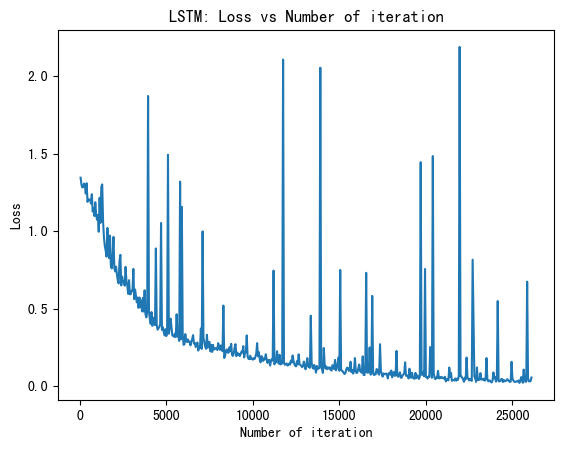

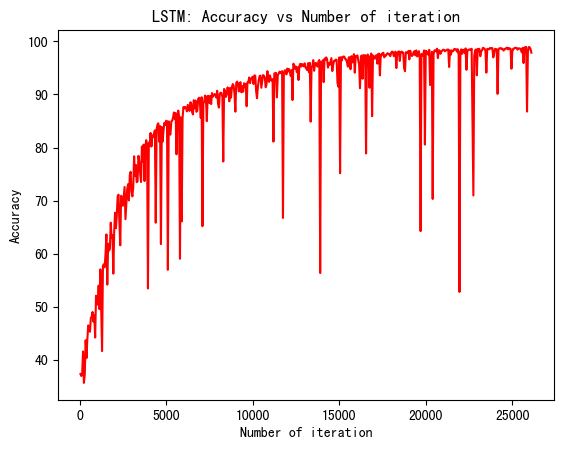

In [10]:
import matplotlib.pyplot as plt
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,torch._to_cpu(accuracy_list),color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()